
# Project Title: Predicting Stock Price Trends Using Historical Data (AAPL)

# Authors:
#   1. Varshini Sherapur Basavarajappa
#   2. Vinisha Purushotham Recharla
#   3. Dharanidhar Reddy Challa
#   4. Sai Nithin Krishna Souram


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import ta
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler


########################################
# CHUNK 3: BACKGROUND, MOTIVATION, AND SIGNIFICANCE
########################################
# Explanation:
#   This project refines our stock prediction approach by adding advanced
#   feature engineering (Bollinger bands, lagged features) and a sliding
#   window for LSTM to improve performance over a simple next-day model.


########################################
# CHUNK 4: RESEARCH QUESTIONS
########################################
# 1. Does adding lagged features (past 5 days) and Bollinger Bands 
#    improve the model’s accuracy in predicting next-day Close?
# 2. Which model—Linear Regression, Random Forest, or LSTM—performs best 
#    with these refined features?
# 3. How does a sliding window approach benefit LSTM for time-series data?





########################################
# CHUNK 5: LOADING DATA AND CLEANING THE DATA
########################################


 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3522 non-null   datetime64[ns]
 1   Close   3522 non-null   float64       
 2   High    3522 non-null   float64       
 3   Low     3522 non-null   float64       
 4   Open    3522 non-null   float64       
 5   Volume  3522 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 165.3 KB


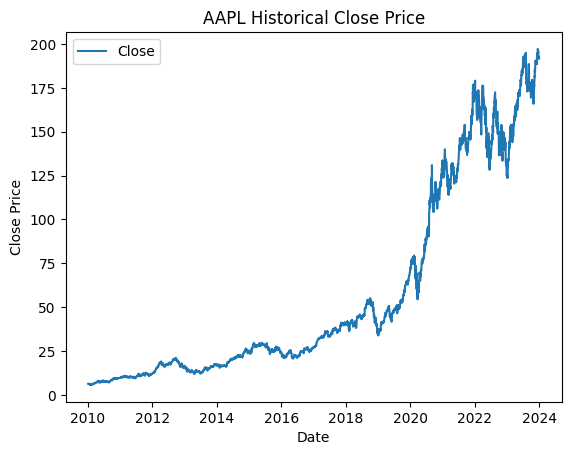

In [7]:
df = pd.read_csv("/Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project/AAPL_stock_data.csv")  # Adjust path if needed

# If 'Price' is actually your Date column, rename it:
df.rename(columns={'Price': 'Date'}, inplace=True)

# Convert 'Date' to datetime format with explicit format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Convert numeric columns to appropriate data types
num_cols = ['Close', 'High', 'Low', 'Open', 'Volume']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values by forward-filling (using .ffill() instead of deprecated fillna)
df.ffill(inplace=True)

# Sort data by Date
df.sort_values(by='Date', inplace=True)

# Reset index after sorting
df.reset_index(drop=True, inplace=True) 

# Display cleaned dataset info
print("\n Cleaned Dataset Info:")
df.info()


# Quick EDA
plt.figure()
plt.title("AAPL Historical Close Price")
plt.plot(df["Date"], df["Close"], label="Close")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

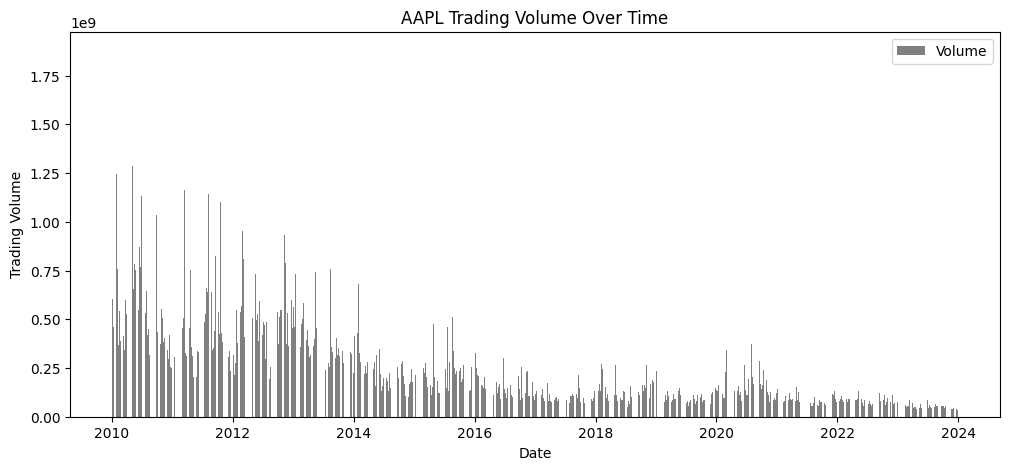

In [8]:
plt.figure(figsize=(12, 5))
plt.bar(df["Date"], df["Volume"], color="gray", label="Volume")
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("AAPL Trading Volume Over Time")
plt.legend()
plt.show()

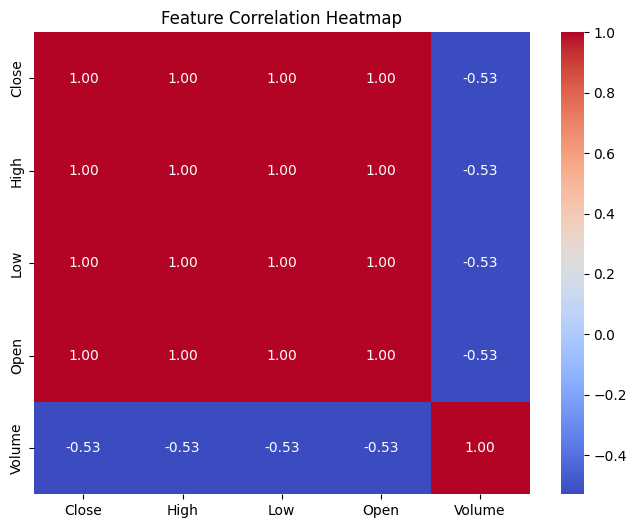

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=["Date"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

########################################
# CHUNK 6: ADVANCED FEATURE ENGINEERING (Bollinger, RSI, Lag Features)
########################################


In [12]:
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert relevant columns to numeric
df["Close"] = pd.to_numeric(df["Close"], errors='coerce')
df["High"] = pd.to_numeric(df["High"], errors='coerce')
df["Low"] = pd.to_numeric(df["Low"], errors='coerce')
df["Open"] = pd.to_numeric(df["Open"], errors='coerce')
df["Volume"] = pd.to_numeric(df["Volume"], errors='coerce')

# Forward fill missing
df.fillna(method="ffill", inplace=True)

# Compute Bollinger Bands
bollinger = BollingerBands(df["Close"], window=20, window_dev=2)
df["BB_High"] = bollinger.bollinger_hband()
df["BB_Low"]  = bollinger.bollinger_lband()
df["BB_Mid"]  = bollinger.bollinger_mavg()
df["BB_Width"] = df["BB_High"] - df["BB_Low"]

# RSI
df["RSI"] = ta.momentum.rsi(df["Close"], window=14)

# MACD
macd_ind = ta.trend.MACD(df["Close"])
df["MACD"] = macd_ind.macd_diff()

# A simple 30-day moving average
df["MA_30"] = df["Close"].rolling(window=30).mean()

# Bollinger & MA may introduce NaN at the start
df.fillna(method="bfill", inplace=True)

# Instead of using today's "Close" as a direct feature, let's use
# "Close(t-1), Close(t-2)..." for the LSTM (and optionally for Random Forest).
# We'll create a function to add lag columns for 'Close'.

def add_lag_features(dataframe, col="Close", n_lags=5):
    # col(t-1), col(t-2), ...
    for i in range(1, n_lags+1):
        dataframe[f"{col}_lag_{i}"] = dataframe[col].shift(i)

# We'll create up to 5-day lags for the close
add_lag_features(df, col="Close", n_lags=5)

# Also for volume if you want to see volume lags:
# add_lag_features(df, col="Volume", n_lags=5)

# Drop any new NaNs after shifting
df.dropna(inplace=True)

# Our target is next day's close => shift -1
df["Target"] = df["Close"].shift(-1)
df.dropna(inplace=True)

# We'll define a list of features (excluding 'Close', because
# we want the model to rely on historical closes from the lags).
selected_features = [
    # "Close",  # intentionally removed
    "Open", "High", "Low", "Volume",
    "BB_High", "BB_Low", "BB_Mid", "BB_Width",
    "RSI", "MACD", "MA_30",
    # Now the 5 lags
    "Close_lag_1", "Close_lag_2", "Close_lag_3", "Close_lag_4", "Close_lag_5"
]

# Convert data to arrays
X_all = df[selected_features].values
y_all = df["Target"].values


/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3834914320.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3834914320.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)


########################################
# CHUNK 7: TRAIN/TEST SPLIT + SCALING
########################################

In [13]:
# Chronological split (80/20)
split_idx = int(len(X_all)*0.8)
X_train_raw = X_all[:split_idx]
X_test_raw  = X_all[split_idx:]
y_train = y_all[:split_idx]
y_test = y_all[split_idx:]

# Scale features for all models
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# Final arrays
X_train = X_train_scaled
X_test  = X_test_scaled


########################################
# CHUNK 8: LINEAR REGRESSION & RANDOM FOREST TUNING
########################################

In [14]:
# -- Model 1: Linear Regression --
linreg = LinearRegression()
linreg.fit(X_train, y_train)
lr_preds = linreg.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae  = mean_absolute_error(y_test, lr_preds)
lr_r2   = r2_score(y_test, lr_preds)
print("\n--- Linear Regression (With Lag Features) ---")
print(f"RMSE: {lr_rmse:.4f}, MAE: {lr_mae:.4f}, R2: {lr_r2:.4f}")


--- Linear Regression (With Lag Features) ---
RMSE: 2.7392, MAE: 2.1026, R2: 0.9802


In [15]:
# -- Model 2: Random Forest with RandomizedSearchCV --
base_rf = RandomForestRegressor(random_state=42)
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}
rf_search = RandomizedSearchCV(
    base_rf,
    param_distributions=param_dist,
    n_iter=5,     # increase for more thorough search
    cv=3,         # 3-fold cross-validation
    scoring="neg_mean_squared_error",
    random_state=42
)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print(f"\nBest RF Params: {rf_search.best_params_}")

rf_preds = best_rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae  = mean_absolute_error(y_test, rf_preds)
rf_r2   = r2_score(y_test, rf_preds)
print("\n--- Random Forest (Lagged Features, Tuned) ---")
print(f"RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R2: {rf_r2:.4f}")




Best RF Params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 30}

--- Random Forest (Lagged Features, Tuned) ---
RMSE: 28.4590, MAE: 22.5621, R2: -1.1386


########################################
# CHUNK 9: LSTM WITH SLIDING WINDOW
########################################

2025-03-12 19:06:44.751714: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-12 19:06:44.751962: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-12 19:06:44.751972: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-12 19:06:44.752209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-12 19:06:44.752234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-12 19:06:44.768485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built wi

Using device: /device:GPU:0
Found GPU at: /device:GPU:0
Epoch 1/50


2025-03-12 19:06:45.313386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 1027.1897 - val_loss: 191.9053
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 39.7549 - val_loss: 124.9756
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 34.7636 - val_loss: 57.9024
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 35.7434 - val_loss: 150.1830
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 33.8975 - val_loss: 90.4361
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 29.8371 - val_loss: 249.6787
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 23.4787 - val_loss: 62.0503
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 35.1796 - val_loss: 55.6033
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 34.4269 - val_loss: 39.3766
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 38.0477 - val_loss: 37.6797
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 26.1074 - val_loss: 160.8744
Epoch 12/50
176/176 ━━

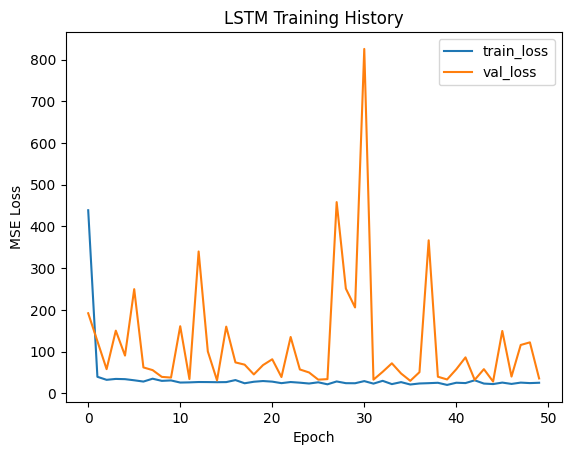

In [16]:
# Check if GPU is available and set the device
device_name = tf.test.gpu_device_name()
if not device_name:
    device_name = '/device:CPU:0'
print('Using device:', device_name)
print('Found GPU at: {}'.format(device_name))

# Set the device for TensorFlow
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
# We'll build sequences of length n_lags_seq for LSTM. 
# Because we already created "Close_lag_1..5", that's a partial approach,
# but let's demonstrate a pure sliding-window approach for LSTM:
n_lags_seq = 5  # same as above, or more (e.g., 10, 20).

def create_sequence_features(Xdata, Ydata, window=n_lags_seq):
    X_seq, Y_seq = [], []
    for i in range(len(Xdata) - window):
        X_seq.append(Xdata[i:i+window])
        Y_seq.append(Ydata[i+window])
    return np.array(X_seq), np.array(Y_seq)

# Apply to training
X_seq_train, y_seq_train = create_sequence_features(X_train, y_train, window=n_lags_seq)
# Apply to test
X_seq_test, y_seq_test = create_sequence_features(X_test, y_test, window=n_lags_seq)

# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_lags_seq, X_train.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = lstm_model.fit(
    X_seq_train, y_seq_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_seq_test, y_seq_test),
    callbacks=[early_stop],
    verbose=1
)

# Predict
lstm_preds_seq = lstm_model.predict(X_seq_test).ravel()

lstm_rmse_seq = np.sqrt(mean_squared_error(y_seq_test, lstm_preds_seq))
lstm_mae_seq  = mean_absolute_error(y_seq_test, lstm_preds_seq)
lstm_r2_seq   = r2_score(y_seq_test, lstm_preds_seq)

print("\n--- LSTM (Sliding Window) Results ---")
print(f"RMSE: {lstm_rmse_seq:.4f}, MAE: {lstm_mae_seq:.4f}, R2: {lstm_r2_seq:.4f}")

# Plot training history
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("LSTM Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


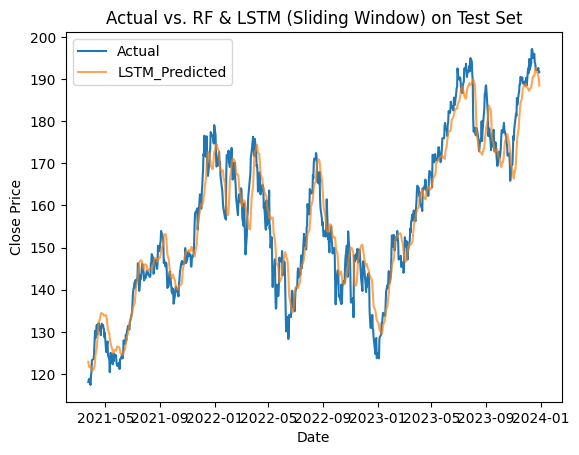

In [17]:
########################################
# CHUNK 10: MODEL PERFORMANCE COMPARISON
########################################

# Because LSTM used a sliding window of size n_lags_seq,
# we lost the first n_lags_seq in the test set for predictions.
n_test_final = len(y_seq_test)

# We align the final LSTM predictions with the last n_test_final points
# of the test set. For RF, LR we have predictions for all test points. 
# Let's just align them by index to make a fair comparison in a smaller range.

# Prepare a shorter version of test predictions for LR, RF
rf_preds_cut  = rf_preds[n_lags_seq:]   # drop the first n_lags_seq points
lr_preds_cut  = lr_preds[n_lags_seq:]
y_test_cut    = y_test[n_lags_seq:]
dates_test_cut = df.iloc[split_idx + n_lags_seq:]["Date"].values  # last portion of the df's dates

results_df = pd.DataFrame({
    "Date": dates_test_cut,
    "Actual": y_test_cut,
    "LR_Pred": lr_preds_cut,
    "RF_Pred": rf_preds_cut,
    "LSTM_Pred": lstm_preds_seq
})

plt.figure()
plt.title("Actual vs. RF & LSTM (Sliding Window) on Test Set")
plt.plot(results_df["Date"], results_df["Actual"], label="Actual")
plt.plot(results_df["Date"], results_df["LSTM_Pred"], label="LSTM_Predicted", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [18]:
########################################
# CHUNK 11: SELECT & SAVE BEST MODEL (Hardcoded Path)
########################################
import os

# Evaluate which model is best by R^2
models_performance = {
    "LinearRegression": {"model": linreg, "r2": lr_r2, "rmse": lr_rmse},
    "RandomForest":     {"model": best_rf, "r2": rf_r2, "rmse": rf_rmse},
    "LSTM":             {"model": lstm_model, "r2": lstm_r2_seq, "rmse": lstm_rmse_seq}
}

best_model_name = max(models_performance, key=lambda m: models_performance[m]["r2"])
best_r2   = models_performance[best_model_name]["r2"]
best_rmse = models_performance[best_model_name]["rmse"]
best_model_obj = models_performance[best_model_name]["model"]

print(f"\n--- Selecting Best Model by R² ---")
print(f"Best model: {best_model_name}")
print(f"R² = {best_r2:.4f}, RMSE = {best_rmse:.4f}")

# HARDCODED folder path to the same directory as your Model_2.ipynb
save_dir = "/Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project"
print(f"Will save model in:\n {save_dir}")

if best_model_name in ["LinearRegression", "RandomForest"]:
    import joblib
    save_path = os.path.join(save_dir, f"{best_model_name}_best_model.pkl")
    joblib.dump(best_model_obj, save_path)
    print(f"Saved '{best_model_name}_best_model.pkl' to:\n {save_path}")
else:
    # LSTM => Keras => .save()
    lstm_save_dir = os.path.join(save_dir, "best_LSTM_model")
    best_model_obj.save(lstm_save_dir)
    print(f"Saved best LSTM model to:\n {lstm_save_dir}")

scaler_path = os.path.join(save_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to: {scaler_path}")




--- Selecting Best Model by R² ---
Best model: LinearRegression
R² = 0.9802, RMSE = 2.7392
Will save model in:
 /Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project
Saved 'LinearRegression_best_model.pkl' to:
 /Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project/LinearRegression_best_model.pkl
Saved scaler to: /Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project/scaler.pkl


In [47]:
print("Random Forest R²:", rf_r2)
print("Random Forest RMSE:", rf_rmse)
print("RandomizedSearchCV Object:", rf_search)
print("Save Path:", save_path)
print("Scaler Object:", scaler)
print("Script Directory:", script_dir)
print("Selected Features:", selected_features)
print("Split Index:", split_idx)
print("All Target Values (y_all):", y_all)
print("Test Sequence Target Values (y_seq_test):", y_seq_test)
print("Train Sequence Target Values (y_seq_train):", y_seq_train)
print("Test Target Values (y_test):", y_test)
print("Cut Test Target Values (y_test_cut):", y_test_cut)
print("Train Target Values (y_train):", y_train)

Random Forest R²: -1.0510322067323132
Random Forest RMSE: 27.855555799211185
RandomizedSearchCV Object: RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error')
Save Path: /Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project/LinearRegression_best_model.pkl
Scaler Object: MinMaxScaler()
Script Directory: /Users/s.sainithinkrishna
Selected Features: ['Open', 'High', 'Low', 'Volume', 'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'RSI', 'MACD', 'MA_30', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5']
Split Index: 2812
All Target Values (y_all): [  6.25791645   6.34618664   6.30943108 ... 192.20835876 192.63627625
 191.5

Random Forest R²: -1.138589864379775
Random Forest RMSE: 28.458951420317998


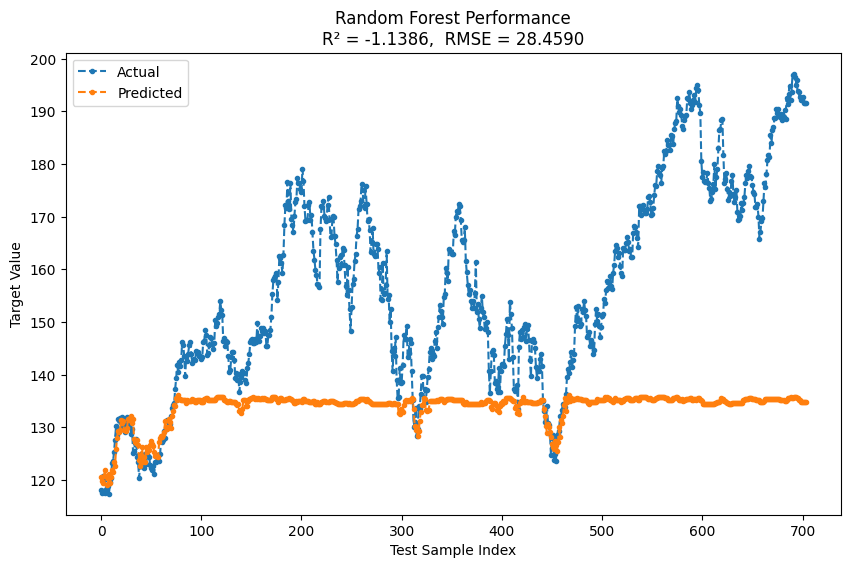

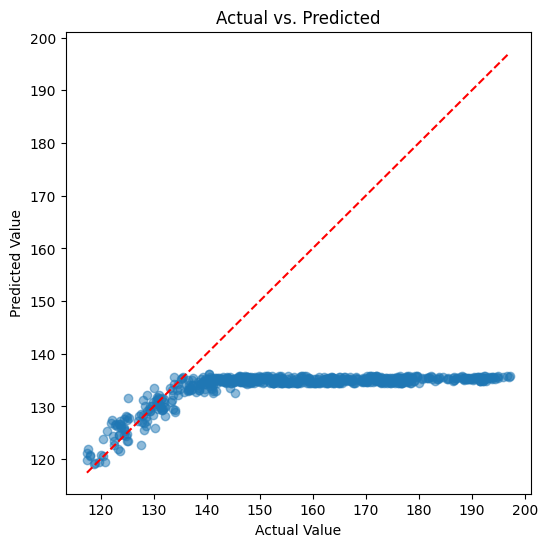

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# 1. Print the stored R² and RMSE
print("Random Forest R²:", rf_r2)
print("Random Forest RMSE:", rf_rmse)

# 2. Generate predictions on the test set (“rf_search” should be your RandomizedSearchCV object)
y_pred = rf_search.best_estimator_.predict(X_test)

# 3. Plot a line chart of Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o', linestyle='dashed', markersize=3)
plt.plot(y_pred, label='Predicted', marker='o', linestyle='dashed', markersize=3)
plt.title(f"Random Forest Performance\nR² = {rf_r2:.4f},  RMSE = {rf_rmse:.4f}")
plt.xlabel("Test Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.show()

# 4. Optionally, plot a scatter of Actual vs. Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
# Plot a 1:1 reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Actual vs. Predicted")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.show()

In [20]:
import joblib

# Load the scaler object from the file
scaler_path = '/Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project/scaler.pkl'
scaler = joblib.load(scaler_path)

# Print the scaler attributes
print("Scaler Data Min:", scaler.data_min_)
print("Scaler Data Max:", scaler.data_max_)
print("Scaler Data Range:", scaler.data_range_)
print("Scaler Scale:", scaler.scale_)
print("Scaler Min:", scaler.min_)
print("Scaler Feature Range:", scaler.feature_range)

Scaler Data Min: [ 5.79547241e+00  5.90483051e+00  5.73160109e+00  4.54480000e+07
  6.18178499e+00  5.64381360e+00  5.97088301e+00  2.76434547e-01
  2.10300629e+01 -2.45703558e+00  6.05451992e+00  5.78583002e+00
  5.78583002e+00  5.78583002e+00  5.78583002e+00  5.78583002e+00]
Scaler Data Max: [1.40419974e+02 1.41876979e+02 1.38239347e+02 1.88099800e+09
 1.41206236e+02 1.26804772e+02 1.33322375e+02 3.40095716e+01
 9.06953005e+01 1.50402327e+00 1.31108226e+02 1.39989716e+02
 1.39989716e+02 1.39989716e+02 1.39989716e+02 1.39989716e+02]
Scaler Data Range: [1.34624502e+02 1.35972148e+02 1.32507746e+02 1.83555000e+09
 1.35024451e+02 1.21160959e+02 1.27351492e+02 3.37331371e+01
 6.96652376e+01 3.96105885e+00 1.25053706e+02 1.34203886e+02
 1.34203886e+02 1.34203886e+02 1.34203886e+02 1.34203886e+02]
Scaler Scale: [7.42806835e-03 7.35444730e-03 7.54672864e-03 5.44795838e-10
 7.40606602e-03 8.25348371e-03 7.85228337e-03 2.96444412e-02
 1.43543614e-02 2.52457749e-01 7.99656427e-03 7.45134909e-03

In [21]:

import yfinance as yf
import joblib
import numpy as np
import pandas as pd
import ta
from ta.volatility import BollingerBands
import os

In [22]:
data = yf.download("AAPL", period="1mo", interval="1d", progress=False)
print(data)

YF.download() has changed argument auto_adjust default to True
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-02-13  241.529999  242.339996  235.570007  236.910004  53614100
2025-02-14  244.600006  245.550003  240.990005  241.250000  40896200
2025-02-18  244.470001  245.179993  241.839996  244.149994  48822500
2025-02-19  244.869995  246.009995  243.160004  244.660004  32204200
2025-02-20  245.830002  246.779999  244.289993  244.940002  32316900
2025-02-21  245.550003  248.690002  245.220001  245.949997  53197400
2025-02-24  247.100006  248.860001  244.419998  244.929993  51326400
2025-02-25  247.039993  250.000000  244.910004  248.000000  48013300
2025-02-26  240.360001  244.979996  239.130005  244.330002  44433600
2025-02-27  237.300003  242.460007  237.059998  239.410004  41153600
2025-02-28  241.839996  242.089996  230.

In [23]:
# Flatten column levels

# If you haven't run the cell that imports RandomForestRegressor, un-comment below:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df = data.copy()
df.columns = df.columns.droplevel(1)

# Create target for next-day volume
df["Target_Volume"] = df["Volume"].shift(-1)
df.dropna(inplace=True)

# Prepare features and target
X = df[["Close", "High", "Low", "Open", "Volume"]]
y = df["Target_Volume"]

# Chronological train/test split (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train a Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

# Example: predict volume for the last available day
last_features = X_test.iloc[[-1]]  # features of the last entry
next_day_volume = model.predict(last_features)[0]
print("Predicted Next-Day Volume:", int(next_day_volume))

RMSE: 20710045.37184138
Predicted Next-Day Volume: 46092563


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3538 - val_loss: 2.3487e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.3295 - val_loss: 4.4139e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.3215 - val_loss: 9.3979e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2994 - val_loss: 0.0018
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3013 - val_loss: 0.0032
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.3025 - val_loss: 0.0051
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2760 - val_loss: 0.0077
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2382 - val_loss: 0.0113
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2360 - val_loss: 0.0160
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2339 - val_loss: 0.0222
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1930 - val_loss: 0.0300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

--- LSTM (Price Prediction) Results ---
RMSE:

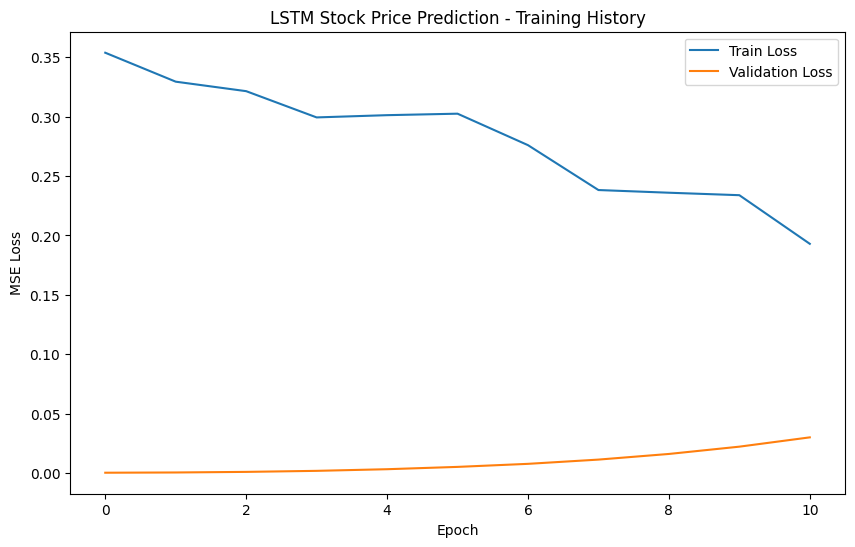

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

Predicted Next-Day Close Price for 2025-03-12: $235.54
Current Close Price (2025-03-11): $220.84


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Prepare the data for LSTM model with Close price as target
def create_sequence_features(Xdata, Ydata, window=5):
    X_seq, Y_seq = [], []
    # Check if we have enough data to create at least one sequence
    if len(Xdata) <= window:
        return np.array([]), np.array([])
    
    for i in range(len(Xdata) - window):
        X_seq.append(Xdata[i:i+window])
        Y_seq.append(Ydata[i+window])
    
    return np.array(X_seq), np.array(Y_seq)

# Create target column for next-day Close price
df_price = data.copy()
df_price.columns = df_price.columns.droplevel(1)  # Flatten the multi-level columns
df_price['Target_Close'] = df_price['Close'].shift(-1)  # Next day's closing price
df_price.dropna(inplace=True)

# Prepare features and target
X_price = df_price[['Open', 'High', 'Low', 'Close', 'Volume']]
y_price = df_price['Target_Close']

# Split data into training and test sets
price_split_index = int(len(df_price) * 0.8)
X_price_train, X_price_test = X_price.iloc[:price_split_index], X_price.iloc[price_split_index:]
y_price_train, y_price_test = y_price.iloc[:price_split_index], y_price.iloc[price_split_index:]

# Scale the data
price_scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on training data only
price_data_train = price_scaler.fit_transform(X_price_train[['Open', 'High', 'Low', 'Close']])
volume_data_train = volume_scaler.fit_transform(X_price_train[['Volume']])
target_data_train = target_scaler.fit_transform(y_price_train.values.reshape(-1, 1))

# Create scaled training data
X_price_train_scaled = np.hstack((price_data_train, volume_data_train))

# Create sequences for LSTM
X_seq_list, y_seq_list = [], []
for i in range(len(X_price_train_scaled) - 5):
    X_seq_list.append(X_price_train_scaled[i:i+5])
    y_seq_list.append(target_data_train[i+5])

X_price_seq_train = np.array(X_seq_list)
y_price_seq_train = np.array(y_seq_list)

# Use part of training data for validation
val_price_split = int(len(X_price_seq_train) * 0.8)
X_price_seq_val = X_price_seq_train[val_price_split:]
y_price_seq_val = y_price_seq_train[val_price_split:]
X_price_seq_train = X_price_seq_train[:val_price_split]
y_price_seq_train = y_price_seq_train[:val_price_split]

# Build LSTM Model for price prediction
price_model = Sequential()
price_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(5, X_price_train_scaled.shape[1])))
price_model.add(Dropout(0.2))
price_model.add(LSTM(32, activation='relu'))
price_model.add(Dropout(0.2))
price_model.add(Dense(1))

# Compile the model
price_model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_price = price_model.fit(
    X_price_seq_train, y_price_seq_train,
    epochs=50, 
    batch_size=16,
    validation_data=(X_price_seq_val, y_price_seq_val),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model on validation set
price_preds_scaled = price_model.predict(X_price_seq_val)
price_preds = target_scaler.inverse_transform(price_preds_scaled).ravel()
y_price_val = target_scaler.inverse_transform(y_price_seq_val).ravel()

price_rmse = np.sqrt(mean_squared_error(y_price_val, price_preds))
price_mae = mean_absolute_error(y_price_val, price_preds)
price_r2 = r2_score(y_price_val, price_preds)

print("\n--- LSTM (Price Prediction) Results ---")
print(f"RMSE: {price_rmse:.4f}, MAE: {price_mae:.4f}, R²: {price_r2:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history_price.history['loss'], label='Train Loss')
plt.plot(history_price.history['val_loss'], label='Validation Loss')
plt.title('LSTM Stock Price Prediction - Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Predict future price (next trading day)
# Get the most recent 5 days of data
last_5_days_data = X_price.iloc[-5:].values
# Scale the data
last_5_days_price = price_scaler.transform(last_5_days_data[:, :4])
last_5_days_volume = volume_scaler.transform(last_5_days_data[:, 4:])
last_5_days_scaled = np.hstack((last_5_days_price, last_5_days_volume))
# Reshape for LSTM input [samples, time steps, features]
last_5_days_scaled = last_5_days_scaled.reshape(1, 5, last_5_days_scaled.shape[1])
# Make prediction and inverse transform to get actual price
next_day_price_scaled = price_model.predict(last_5_days_scaled)
next_day_price = target_scaler.inverse_transform(next_day_price_scaled)[0][0]

# Get the predicted date (next trading day)
last_date = X_price.index[-1]
next_date = last_date + pd.Timedelta(days=1)
# Check if next_date is a weekend and adjust if needed
if next_date.weekday() >= 5:  # 5=Saturday, 6=Sunday
    next_date = next_date + pd.Timedelta(days=(7 - next_date.weekday()))

print(f"\nPredicted Next-Day Close Price for {next_date.date()}: ${next_day_price:.2f}")
print(f"Current Close Price ({last_date.date()}): ${X_price['Close'].iloc[-1]:.2f}")


In [25]:
import os
import joblib
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from ta.volatility import BollingerBands

def predict_next_day_close(ticker="AAPL", days_of_history=60):
    """
    1) Load best model & scaler from disk
    2) Download 'days_of_history' of data from Yahoo Finance
    3) Flatten multi-index columns if needed
    4) Ensure columns are single-level & 1D
    5) Compute Bollinger, RSI, MACD, MA_30, and Close_lag_1..5
    6) Build a 16-column feature array in the same order used for training
    7) Scale & predict next day's close
    """

    #=== 1) Load model & scaler ===#
    save_dir   = "/Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project"
    model_path = os.path.join(save_dir, "LinearRegression_best_model.pkl")
    scaler_path= os.path.join(save_dir, "scaler.pkl")

    best_model = joblib.load(model_path)
    scaler     = joblib.load(scaler_path)

    #=== 2) Download data ===#
    end_date   = pd.Timestamp.today()
    start_date = end_date - pd.Timedelta(days=days_of_history)
    data       = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"No data from Yahoo Finance for {ticker} in given range.")

    # Standard cleanup
    data.reset_index(inplace=True)
    data.sort_values("Date", inplace=True)
    data.fillna(method="ffill", inplace=True)

    #=== 3) Flatten multi-index columns, rename them to single-level columns if needed ===#
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [
            "_".join(str(col_part) for col_part in col).strip("_")
            for col in data.columns.to_flat_index()
        ]
    # For example, rename 'Close_AAPL' to 'Close' if it exists
    rename_map = {}
    for col in data.columns:
        if "Close" in col and col != "Date":
            rename_map[col] = "Close"
        elif "Open" in col and col != "Date":
            rename_map[col] = "Open"
        elif "High" in col and col != "Date":
            rename_map[col] = "High"
        elif "Low" in col and col != "Date":
            rename_map[col] = "Low"
        elif "Volume" in col:
            rename_map[col] = "Volume"
    data.rename(columns=rename_map, inplace=True)

    #=== 4) Ensure columns are 1D (squeeze) ===#
    for col in ["Open","High","Low","Close","Volume"]:
        if col in data.columns and len(data[col].shape) > 1:
            data[col] = data[col].squeeze()

    #=== 5) Compute technicals: Bollinger, RSI, MACD, MA_30, lags ===#
    if "Close" not in data.columns:
        raise ValueError("Column 'Close' not found after flattening/renaming.")

    # 5.1 Bollinger
    bb = BollingerBands(close=data["Close"], window=20, window_dev=2)
    data["BB_High"]  = bb.bollinger_hband()
    data["BB_Low"]   = bb.bollinger_lband()
    data["BB_Mid"]   = bb.bollinger_mavg()
    data["BB_Width"] = data["BB_High"] - data["BB_Low"]

    # 5.2 RSI & MACD
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)
    macd_obj    = ta.trend.MACD(data["Close"])
    data["MACD"] = macd_obj.macd_diff()

    # 5.3 MA_30
    data["MA_30"] = data["Close"].rolling(window=30).mean()

    # 5.4 Lags: "Close_lag_1..5"
    for i in range(1,6):
        data[f"Close_lag_{i}"] = data["Close"].shift(i)

    data.fillna(method="bfill", inplace=True)

    # We need at least 30 days + 5 lags, so ensure there's enough data
    if len(data) < 30 + 5:
        raise ValueError("Not enough data to compute 30-day MA + 5 lags. Try increasing 'days_of_history'.")

    #=== 6) Build the final 16-column array from the last row ===#
    # EXACT order from training:
    # 1) "Open"
    # 2) "High"
    # 3) "Low"
    # 4) "Volume"
    # 5) "BB_High"
    # 6) "BB_Low"
    # 7) "BB_Mid"
    # 8) "BB_Width"
    # 9) "RSI"
    # 10) "MACD"
    # 11) "MA_30"
    # 12) "Close_lag_1"
    # 13) "Close_lag_2"
    # 14) "Close_lag_3"
    # 15) "Close_lag_4"
    # 16) "Close_lag_5"

    last_row = data.iloc[-1]
    features_16 = [
        float(last_row["Open"]),
        float(last_row["High"]),
        float(last_row["Low"]),
        float(last_row["Volume"]),
        float(last_row["BB_High"]),
        float(last_row["BB_Low"]),
        float(last_row["BB_Mid"]),
        float(last_row["BB_Width"]),
        float(last_row["RSI"]),
        float(last_row["MACD"]),
        float(last_row["MA_30"]),
        float(last_row["Close_lag_1"]),
        float(last_row["Close_lag_2"]),
        float(last_row["Close_lag_3"]),
        float(last_row["Close_lag_4"]),
        float(last_row["Close_lag_5"]),
    ]
    row_array  = np.array(features_16, dtype=float).reshape(1, -1)

    # Check shape matches the scaler's "n_features_in_"
    if row_array.shape[1] != scaler.n_features_in_:
        raise ValueError(
            f"Constructed row has {row_array.shape[1]} features but scaler expects {scaler.n_features_in_}.\n"
            f"Features used: {features_16}"
        )

    row_scaled = scaler.transform(row_array)

    #=== 7) Predict next-day close ===#
    predicted_close = best_model.predict(row_scaled)[0]
    return predicted_close

# Example usage
if __name__ == "__main__":
    pred_close = predict_next_day_close("AAPL", days_of_history=65)  
    # 65 days to be safe for 30-day MA + 5 lags
    tomorrow   = pd.Timestamp.today() + pd.Timedelta(days=1)
    print(f"\nPredicted next-day CLOSE for {tomorrow.date()}: ${pred_close:.2f}")
    



Predicted next-day CLOSE for 2025-03-13: $218.23


/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/324314706.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/324314706.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)



--- Production Backtest Results ---


/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3830286333.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3830286333.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  slice_data.fillna(method="bfill", inplace=True)
/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3830286333.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  slice_data.fillna(method="bfill", inplace=True)
/var/folders/yq/_7fq7s8d3tggxd87vdc8q4hc0000gn/T/ipykernel_7356/3830286333.py:107: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or ob

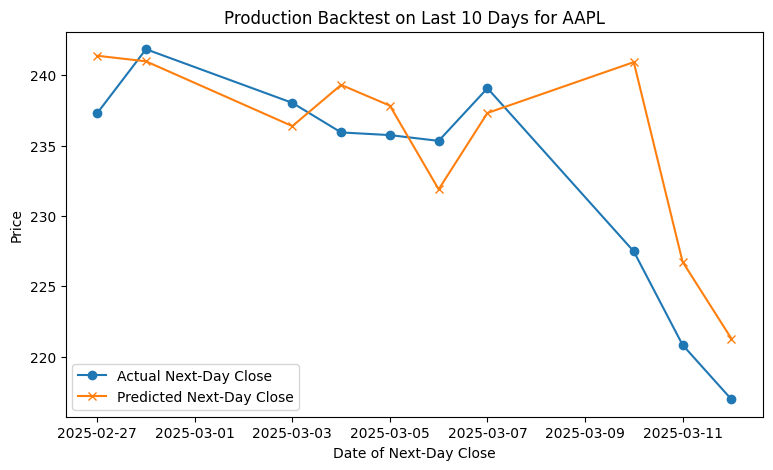

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from ta.volatility import BollingerBands
import joblib

def plot_production_backtest(ticker="AAPL", days_of_history=70, lookback_days=10,
                             best_model=None, scaler=None):
    """
    A mini “sliding” backtest:
      1) Download 'days_of_history' of data from yfinance.
      2) For each day in the last `lookback_days`, compute features 
         (Bollinger, RSI, MACD, MA_30, lags) as if that day is "today".
      3) Predict "tomorrow" using the same columns as training (16 features).
      4) Compare with actual tomorrow's close.
      5) Plot predicted vs. actual next-day close.

    best_model:   pre-loaded scikit-learn model with 16 features
    scaler:       pre-loaded MinMaxScaler that matches training columns
    """

    if best_model is None or scaler is None:
        raise ValueError("Must provide 'best_model' and 'scaler' to this function.")

    #=== 1) Download data ===#
    end_date   = pd.Timestamp.today()
    start_date = end_date - pd.Timedelta(days=days_of_history)
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if data.empty:
        raise ValueError(f"No data from Yahoo for {ticker} with {days_of_history} days.")

    data.reset_index(inplace=True)
    data.sort_values("Date", inplace=True)
    data.fillna(method="ffill", inplace=True)

    # For safety, ensure single-level columns with known names if there's a MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [
            "_".join(str(c) for c in col).strip("_")
            for col in data.columns.to_flat_index()
        ]

    # Possibly rename columns if they're "Close_AAPL" etc. to just "Close", "Open", ...
    rename_map = {}
    for col in data.columns:
        if "Close" in col and col != "Date":
            rename_map[col] = "Close"
        elif "Open" in col and col != "Date":
            rename_map[col] = "Open"
        elif "High" in col and col != "Date":
            rename_map[col] = "High"
        elif "Low" in col and col != "Date":
            rename_map[col] = "Low"
        elif "Volume" in col:
            rename_map[col] = "Volume"
    data.rename(columns=rename_map, inplace=True)

    # We'll track predicted vs. actual tomorrow closes
    predictions = []
    actuals = []
    dates_for_plot = []

    last_index = len(data) - 1
    first_index_for_backtest = max(0, last_index - lookback_days)

    for i in range(first_index_for_backtest, last_index):
        if i+1 > last_index:
            break  # no next-day actual

        today_date    = data["Date"].iloc[i]
        tomorrow_date = data["Date"].iloc[i+1]

        #=== 2) In-memory slice up to day i
        slice_data = data.iloc[:(i+1)].copy()

        # Force each relevant column to be a 1D float Series
        for col in ["Open","High","Low","Close","Volume"]:
            if col in slice_data.columns:
                # If shape is (N,1), squeeze it
                if len(slice_data[col].shape) > 1 and slice_data[col].shape[1] == 1:
                    slice_data[col] = slice_data[col].squeeze()
                # Convert to float
                slice_data[col] = slice_data[col].astype(float)

        #=== 3) Compute Bollinger, RSI, MACD, MA_30, lags ===#
        # Bollinger must see a *Series*, not array
        if "Close" not in slice_data.columns:
            raise ValueError("No 'Close' column after flattening/rename.")
        bb = BollingerBands(close=slice_data["Close"], window=20, window_dev=2)
        slice_data["BB_High"]  = bb.bollinger_hband()
        slice_data["BB_Low"]   = bb.bollinger_lband()
        slice_data["BB_Mid"]   = bb.bollinger_mavg()
        slice_data["BB_Width"] = slice_data["BB_High"] - slice_data["BB_Low"]

        slice_data["RSI"] = ta.momentum.rsi(slice_data["Close"], window=14)
        macd_obj          = ta.trend.MACD(slice_data["Close"])
        slice_data["MACD"] = macd_obj.macd_diff()

        slice_data["MA_30"] = slice_data["Close"].rolling(window=30).mean()

        # Lags
        for lag in range(1,6):
            slice_data[f"Close_lag_{lag}"] = slice_data["Close"].shift(lag)

        slice_data.fillna(method="bfill", inplace=True)

        #=== 4) The last row is day i
        last_row = slice_data.iloc[-1]

        # Build the 16 columns in training order
        # EXACT order from your training code:
        # 1) "Open",
        # 2) "High",
        # 3) "Low",
        # 4) "Volume",
        # 5) "BB_High",
        # 6) "BB_Low",
        # 7) "BB_Mid",
        # 8) "BB_Width",
        # 9) "RSI",
        # 10) "MACD",
        # 11) "MA_30",
        # 12) "Close_lag_1",
        # 13) "Close_lag_2",
        # 14) "Close_lag_3",
        # 15) "Close_lag_4",
        # 16) "Close_lag_5"

        features_16 = [
            float(last_row["Open"]),
            float(last_row["High"]),
            float(last_row["Low"]),
            float(last_row["Volume"]),
            float(last_row["BB_High"]),
            float(last_row["BB_Low"]),
            float(last_row["BB_Mid"]),
            float(last_row["BB_Width"]),
            float(last_row["RSI"]),
            float(last_row["MACD"]),
            float(last_row["MA_30"]),
            float(last_row["Close_lag_1"]),
            float(last_row["Close_lag_2"]),
            float(last_row["Close_lag_3"]),
            float(last_row["Close_lag_4"]),
            float(last_row["Close_lag_5"]),
        ]
        row_array  = np.array(features_16, dtype=float).reshape(1, -1)

        # Scale & predict
        row_scaled = scaler.transform(row_array)
        pred_close_tomorrow = best_model.predict(row_scaled)[0]

        # Actual tomorrow
        actual_close_tomorrow = float(data["Close"].iloc[i+1])

        predictions.append(pred_close_tomorrow)
        actuals.append(actual_close_tomorrow)
        dates_for_plot.append(tomorrow_date)

    #=== 5) Plot them
    print("\n--- Production Backtest Results ---")
    plt.figure(figsize=(9,5))
    plt.plot(dates_for_plot, actuals, marker='o', label="Actual Next-Day Close")
    plt.plot(dates_for_plot, predictions, marker='x', label="Predicted Next-Day Close")
    plt.title(f"Production Backtest on Last {lookback_days} Days for {ticker}")
    plt.xlabel("Date of Next-Day Close")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load model & scaler from disk
    save_dir = "/Users/s.sainithinkrishna/Downloads/ADVANCED_MACHINE_LEARNING/Project"
    model_path  = os.path.join(save_dir, "LinearRegression_best_model.pkl")
    scaler_path = os.path.join(save_dir, "scaler.pkl")

    best_model = joblib.load(model_path)
    scaler     = joblib.load(scaler_path)

    plot_production_backtest(
        "AAPL",
        days_of_history=70,
        lookback_days=10,
        best_model=best_model,
        scaler=scaler
    )
